# Imports

In [1]:
import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
#from sklearn import tree

import statsmodels.api as sm
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed

import warnings
warnings.filterwarnings("ignore")

import loo_q2 as loo

randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    # plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker=".",facecolor='none',s=200)
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker=".",s=200) # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color='red',marker=".",linewidth=3, s=200)     #,alpha=0.25  "#8da9f5"
    plt.plot(y_train,yy_fit_line,color="darkgrey",linestyle='--',dashes=[5,15]) #,alpha=0.2
    if leg:
        plt.legend(loc='lower right', fontsize=10)
    plt.xlabel(label+" measured",fontsize=18, fontweight='bold')
    plt.ylabel(label+" predicted",fontsize=18, fontweight='bold')
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav, dpi=300, bbox_inches='tight', transparent=True)
        
def r2_val(y_test,y_pred_test,y_train):
    """Calculates the external R2 pred as described:
    https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
    y_resid = y_pred_test - y_test
    SS_resid = np.sum(y_resid**2)
    y_var = y_test - np.mean(y_train)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_resid/SS_total
    return(r2_validation)

def repeated_k_fold(X_train,y_train,reg = LinearRegression(), k=3, n=100):
    """Reapeated k-fold cross-validation. 
    For each of n repeats, the (training)data is split into k folds. 
    For each fold, this part of the data is predicted using the rest. 
    Once this is done for all k folds, the coefficient of determination (R^2) of the predictions of all folds combined (= the complete data set) is evaluated
    This is repeated n times and all n R^2 are returned for averaging/further analysis
    """
    
    rkf = RepeatedKFold(n_splits=k, n_repeats=n)
    r2_scores = []
    y_validations,y_predictions = np.zeros((np.shape(X_train)[0],n)),np.zeros((np.shape(X_train)[0],n))
    foldcount = 0
    for i,foldsplit in enumerate(rkf.split(X_train)):
        fold, rep = i%k, int(i/k) # Which of k folds. Which of n repeats
        model = reg.fit(X_train[foldsplit[0]],y_train[foldsplit[0]]) # foldsplit[0]: k-1 training folds
        y_validations[foldcount:foldcount+len(foldsplit[1]),rep] = y_train[foldsplit[1]] # foldsplit[1]: validation fold
        y_predictions[foldcount:foldcount+len(foldsplit[1]),rep]  = model.predict(X_train[foldsplit[1]])
        foldcount += len(foldsplit[1])
        if fold+1==k:
            foldcount = 0
    r2_scores = np.asarray([metrics.r2_score(y_validations[:,rep],y_predictions[:,rep]) for rep in range(n)])
    return(r2_scores)

# keepmodels = []

import random
insu = ["yikes. that's ass.","LMAO do not publish this what are you doing","oof.","that's a rough one","I'm embarassed to even print this, but here it is:","more disappointing than an unsalted pretzel","this model makes onions cry","did you get this model from Joe?","remember, these stats aren't an insult, they're just describing your model","this model reminds me - I gotta take out the trash","don't worry - the first 40 years of modeling are always the hardest","this model has miles to go before it reaches mediocre","the bad model store called. they're running out of your models"]

# Reading data

In [ ]:
conda env export > environment_2.yml

## Single File

In [2]:
# all data in a single file
excel_file ="aMD_with_IFD_010822" 
excel_sheet = "ddG" #"singlesub" #"no_NH_no_diffaryl" 
num_par = 961  
par_start_col = 2 #4  # 0-indexed
num_samples = 65 
response_col = 1 #2   # 0-indexed
y_label_col = 0    # 0-indexed

apply_mask = True # remove samples with empty response
verbose = True
xlabelrow = True


inp = pd.read_excel(excel_file+".xlsx",excel_sheet,header=0,index_col=y_label_col,nrows=num_samples+int(xlabelrow),
                    usecols=list(range(0,(num_par+par_start_col))))

if xlabelrow:
    X_names = list(inp.iloc[0,par_start_col-1:num_par+par_start_col-1]) 
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1] 
    resp_label = list(inp.columns)[response_col-1]
    inp.drop(index=inp.index[0],inplace=True)
else:
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    X_names = X_labels
    resp_label = list(inp.columns)[response_col-1]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))
y = np.asarray(inp[resp_label],dtype=np.float)
X = np.asarray(inp[X_labels],dtype=np.float)
y_labels = np.asarray(list(inp.index),dtype=str)
y_labels_comp= y_labels

if apply_mask:
    mask = y.nonzero()[0]
    mask = ~np.isnan(y)
    print("n_samples before removing empty cells: {}".format(len(y)))
    print("Removing {} samples.".format(len(y)-sum(mask)))
    X = X[np.array(mask)]
    y = y[np.array(mask)]
    y_labels = y_labels[np.array(mask)]
X_all = X
if verbose:
    print("Shape X: {}".format(X.shape))
    print("Shape y: {}".format(y.shape)) 
    print("Shape labels: {}".format(y_labels.shape)) 
    print("First X cell: {}".format(X[0,0]))
    print("Last X cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label: {}".format(y_labels[-1]))
    #print(inp.head())

n_samples before removing empty cells: 65
Removing 0 samples.
Shape X: (65, 961)
Shape y: (65,)
Shape labels: (65,)
First X cell: 228.2
Last X cell:  0.010000000000000231
First y: -1.4836863905532456
Last y:  -0.996746917
Last label: gluER-T36A-Y343W-5a


## Separate Files

In [ ]:
## separate files for exp data and comp data

comp_file = "Phosphine_library_DFT_props_191120_copy" 
comp_sheet = "selprops_use_2_bowls" 
num_par = 182 
par_start_col = 1   # 0-indexed
comp_num_samples = 1359 
y_label_col_comp = 0  # 0-indexed

exp_file = "exp_bowls" 
exp_sheet = "Sheet1"
exp_num_samples = 10 
response_col = 9  # 0-indexed
y_label_col_exp = 0  # 0-indexed

compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,nrows=comp_num_samples+1,usecols=list(range(0,(num_par+par_start_col))))
compinp.index = compinp.index.map(str)
expinp = pd.read_excel(exp_file+".xlsx",exp_sheet,header=4,index_col=y_label_col_exp,nrows=exp_num_samples,usecols=list(range(0,response_col+1)))
expinp.index = [i.zfill(4) for i in expinp.index.map(str)]

xlabelrow = True
verbose = True

X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]
compinp.drop(index=compinp.index[0],inplace=True)
X_all = np.asarray(compinp[X_labels],dtype=np.float)
y_labels_comp = np.asarray(list(compinp.index),dtype=str)
compnan = np.isnan(X_all).any(axis=1)
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))

resp_label = list(expinp.columns)[response_col-1]
y = np.asarray(expinp.iloc[:,response_col-1],dtype=np.float)
y_labels_exp = np.asarray(list(expinp.index),dtype=str)

mask_y = y.nonzero()[0]
mask_y = ~np.isnan(y)
mask_X = np.array([True if i in y_labels_comp else False for i in y_labels_exp])
mask = mask_y&mask_X
print("n_samples before removing empty cells: {}".format(len(y)))
print("Removing {} samples.".format(len(y)-sum(mask)))
y = y[np.array(mask)]
y_labels = y_labels_exp[np.array(mask)]

X = np.asarray(compinp.loc[y_labels],dtype=np.float)

if verbose:
    print("Shape X (all): {}".format(X_all.shape))
    print("Shape X (exp): {}".format(X.shape))
    print("Shape y (exp): {}".format(y.shape)) 
    print("Shape labels (exp): {}".format(y_labels.shape)) 
    print("First X (exp) cell: {}".format(X[0,0]))
    print("Last X (exp) cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label exp: {}".format(y_labels[-1]))
    print("Last label comp: {}".format(y_labels_comp[-3:]))
    #print(inp.head())

# Basic visualization

## Histograms and univariate correlations

### OG

In [ ]:
# original data
# Visualize Histograms and univariate correlations for all (or selected) features
features = range(np.shape(X)[1])   # iterate over all features
# examples for selecting features
#specify names:
# features = [x_names.index("sterimol_5-.5cB5_max")]
#specify x-numbers (1-indexed):
#features_x = ["x139","x140","x141","x142","x143","x144","x145","x146","x147","x148","x149","x150","x151","x152","x153","x154","x155","x156","x157","x158","x159","x160","x161","x162","x163"]
#features = [X_labels.index(i) for i in features_x]
#specify ranges (0-indexed)
#features = itertools.chain(range(15,92)) #480,2611)) #312,343)) 

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind], y)
    fit_line = intercept+slope*X[:,f_ind]
    
    plt.figure(figsize=(9, 4))
    
    plt.subplot(1,2,1)
    plt.hist(X[:,f_ind], bins="auto")
    plt.ylabel("frequency",fontsize=20)
    plt.xlabel(feature + " " + X_names[f_ind],fontsize=20)
    
    plt.subplot(1,2,2)
    plt.scatter(X[:,f_ind], y,color="black",marker="s",alpha=0.5)    
    plt.plot(X[:,f_ind],fit_line,color="black")
    plt.xlabel(feature + " " + X_names[f_ind],fontsize=20)
    plt.ylabel("y",fontsize=20) # "$ΔΔG^{≠}$"  "Yield"

#     plt.xticks(np.arange(round(min(X[:,f_ind])-0.005,3), round(max(X[:,f_ind])+0.005,3), 0.03),fontsize=15)
    plt.yticks(fontsize=15)        
    plt.tight_layout()
    plt.show()    

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n")
    
  

### Seaborn

In [ ]:
# has option to only print univariate correlations if they meet an R^2 cutoff

### All features:
features = range(np.shape(X)[1])
### Features by X-numbers (1-indexed):
#features_x = ["x1","x19","x20","x31","x120","x145","x160"]
#features_x = ["x231"]
#features = [X_labels.index(i) for i in features_x]
### Feature by range (0-indexed):
# features = itertools.chain(range(75,85),range(90,95))

#set r2 cutoff
r2_cutoff = 0.4
r2_values = []

for f_ind in features:
    feature = X_labels[f_ind]
    slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind], y)
    fit_line = intercept+slope*X[:,f_ind]
    r2 = r_value**2
    r2_values.append(r2)
    if r2 >= r2_cutoff:
        print(feature, X_names[f_ind])
        plt.figure(figsize=(12, 6))
        plt.subplot(1,2,1)
        plt.hist(X[:,f_ind], bins="auto")
        plt.ylabel("frequency",fontsize=12)
        plt.xlabel(feature + " " + X_names[f_ind],fontsize=12)
        plt.tight_layout()
        plt.subplot(1,2,2)
        sns.set_style("white")
        sns.regplot(X[:,f_ind],y,ci=95,truncate=False)
        x_max=np.max(X[:,f_ind])
        x_min=np.min(X[:,f_ind])
        y_max=np.max(y)
        y_min=np.min(y)
        delta_x = 0.05 * (x_max-x_min)
        delta_y = 0.05 * (y_max-y_min)
        plt.xlim([x_min-delta_x,x_max+delta_x])
        plt.ylim([y_min-delta_y,y_max+delta_y])
        #plt.scatter(X[:,f_ind], y,color="black",marker=".",alpha=0.5,s=150)
        #plt.plot(X[:,f_ind],fit_line,color="black")
        plt.xlabel(feature + " " + X_names[f_ind],fontsize=18)
        plt.ylabel("y",fontsize=18)  # "$ΔΔG^{≠}$"  "Yield"
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        
        #toggle these two lines to either show or show and save the plots
        plt.show()
        #plt.savefig("plotname.png",dpi=300)
        
        if p_value > 0.01:
            print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
        else:
            print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
        print("\n--------------------------------------------------------------------------------------------------------------------------\n")

## plot a feature vs. another feature

In [ ]:
# one comparison plot at a time

# select two features to visualize
# can be integer-index of features, or string with x-number
f_ind_1 = "x171"
f_ind_2 = "x71"

if type(f_ind_1) == str:
    [f_ind_1,f_ind_2] = [X_labels.index(i) for i in [f_ind_1,f_ind_2]]

print(X_labels[f_ind_1], X_names[f_ind_1])
print(X_labels[f_ind_2], X_names[f_ind_2])
print("\n{} samples".format(np.shape(X[:,f_ind_1])[0]))
slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind_1],X[:,f_ind_2])
fit_line = intercept+slope*X[:,f_ind_1]
print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

plt.figure(figsize=(13, 4))

plt.subplot(1,3,1)
plt.hist(X[:,f_ind_1], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_labels[f_ind_1] + " " + X_names[f_ind_1])
plt.subplot(1,3,2)
plt.hist(X[:,f_ind_2], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_labels[f_ind_2] + " " + X_names[f_ind_2])

plt.subplot(1,3,3)
plt.scatter(X[:,f_ind_1], X[:,f_ind_2],color="black",marker="s")    
#plt.plot(X[:,f_ind_1],fit_line)
plt.xlabel(X_labels[f_ind_1] + " " + X_names[f_ind_1])
plt.ylabel(X_labels[f_ind_2] + " " + X_names[f_ind_2])
plt.tight_layout()
plt.show()    

In [ ]:
# multpile plots set by ranges
# shows only plots as set by criteria below

feats_to_check1 = itertools.chain(range(48,49),range(72,73)) 
feats_to_check2 = range(150,190) 

for i in feats_to_check1:
    num1 = i
    x_format1 = "x{}".format(num1 + 1)
    if type(x_format1) == str:
            [x_format1] = [X_labels.index(i) for i in [x_format1]]
    for p in feats_to_check2:
        num2 = p
        x_format2 = "x{}".format(num2)
        
        #---
        if type(x_format2) == str:
            [x_format2] = [X_labels.index(i) for i in [x_format2]]
        #print(i,x_format1,type(x_format1))
        #print(p,x_format2,type(x_format2))

        if x_format1 != x_format2:
            print(X_labels[x_format1], X_names[x_format1])
            print(X_labels[x_format2], X_names[x_format2])
            print("\n{} samples".format(np.shape(X[:,x_format1])[0]))
            slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,x_format1],X[:,x_format2])
            fit_line = intercept+slope*X[:,x_format1]
            print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
            
            #show only plots satisfying these criteria:
            if r_value > 0.2:
                plt.figure(figsize=(13, 4))
                
                plt.subplot(1,3,1)
                plt.hist(X[:,x_format1], bins="auto",color="black")
                plt.ylabel("frequency")
                plt.xlabel(X_labels[x_format1] + " " + X_names[x_format1])
                plt.subplot(1,3,2)
                plt.hist(X[:,x_format2], bins="auto",color="black")
                plt.ylabel("frequency")
                plt.xlabel(X_labels[x_format2] + " " + X_names[x_format2])
                
                plt.subplot(1,3,3)
                plt.scatter(X[:,x_format1], X[:,x_format2],color="black",marker="s")    
                #plt.plot(X[:,f_ind_1],fit_line)
                
                # label by x number
                #plt.xlabel(X_labels[num1])
                #plt.ylabel(X_labels[num2])
                # label by x name           
                plt.xlabel(X_labels[x_format1] + " " + X_names[x_format1])
                plt.ylabel(X_labels[x_format2] + " " +X_names[x_format2])
                plt.tight_layout()
            
            
                plt.show()   
                
            print("\n---------------------------------------------------------------------------------------------------------------\n")
            

## Bubble Plot

### parm v parm, sized by y

In [ ]:
# set x, y, and size dimensions, set plot title
bp_x = "x49"
bp_y = "x73"
#bp_size = "s2_3.5h_%yield(avg)"
#bp_title = "parm v parm sized by y"


#figure size
plt.figure(figsize=(8,8))
# use the scatterplot function to build the bubble map
sns.scatterplot(data=inp, 
                x=bp_x,                   #set x
                y=bp_y,                   #set y
                size=bp_size,             #set size
                sizes=(50, 300),          #set size range
                alpha=0.7,                #set transparency
                color="mediumslateblue",  #set color of points
                marker="D")               #set marker shape

#toggle this to label data points with IDs
#for i in range(0,inp.shape[0]):
#    plt.text(inp[bp_x][i]-0.002, inp[bp_y][i]+0.0001, inp.index[i], size="small")
    
#set x,y limits, place legend outside of plot, set title
plt.xlim((round(min(inp[bp_x]),2)-0.01),(round(max(inp[bp_x]),2)+0.01)) 
plt.ylim((round(min(inp[bp_y]),2)-0.01),(round(max(inp[bp_y]),2)+0.01))
plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0)
plt.title(bp_title)

# show or save the graph
plt.show()
#plt.savefig("plotname",format=png,dpi=300)

### with virtual entries

In [ ]:
#plots exp entires by size and virtual entries on top with different marker
#requires a column labeled "virtual" with 1=virtual structure, 0=experimental structure. put 0s in the ycolumns for these

# set x, y, and size dimensions, set plot title
bp_x = "x49"
bp_y = "x73"
bp_size = "s2_3.5h_%yield(avg)"
bp_title = "parm v parm sized by y"
#set colors for exp (0) and virtual (1)
palette = {0:"tomato",
           1:"royalblue"}

#figure size
plt.figure(figsize=(8,8))
# use the scatterplot function to build the bubble map
sns.scatterplot(data=bp_df, 
                x=bp_x,                   #set x
                y=bp_y,                   #set y
                size=bp_size,             #set size
                sizes=(50, 500),          #set size range
                alpha=0.7,                #set transparency
                hue=inp['virtual'],       #color points by virtual or exp
                style=inp['virtual'],     #set point markers by virtual or exp
                palette=palette)          #use defined colors

#toggle this to label data points or not
#for i in range(0,inp.shape[0]):
#    plt.text(inp[bp_x][i]+0.0002, inp[bp_y][i], inp.index[i], size="small")

#set x,y limits, place legend outside of plot, set title
plt.xlim((round(min(inp[bp_x]),2)-0.005),(round(max(inp[bp_x]),2)+0.005)) 
plt.ylim((round(min(inp[bp_y]),2)-0.005),(round(max(inp[bp_y]),2)+0.005))
plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0)
plt.title(bp_title)

# show or save the graph
plt.show()
#plt.savefig("plotname",format=png,dpi=300)

print("note: virtual ligands sized arbitrarily")

## Correlation Map

### OG

In [ ]:
# uncomment this line to use an interactive plot 
# %matplotlib notebook

corrmap = np.corrcoef(X.T)

plt.matshow(corrmap)
plt.xticks(range(len(X_labels)),X_labels, fontsize=10, rotation=90)
plt.yticks(range(len(X_labels)),X_labels, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

### Seaborn

In [ ]:
# uncomment this line to use an interactive plot 
#%matplotlib notebook

import seaborn as sns

corrmap = np.corrcoef(X.T)

plt.subplots(figsize=(15,15))
sns.heatmap(corrmap,center=0, annot=False, cmap="coolwarm", cbar=True) #linewidths=0.5
plt.xticks(range(len(X_labels)),X_labels, fontsize=10, rotation=90)
plt.yticks(range(len(X_labels)),X_labels, fontsize=10)


## Single-node Decision Tree

### Regression

In [ ]:
# import graphviz 

dt = DecisionTreeRegressor(max_depth=1).fit(X, y)
print("Accuracy: {:.2f}".format(dt.score(X, y)))

feat = int(np.where(dt.feature_importances_ != 0)[0])
print(X_labels[feat],X_names[feat])

plt.figure(figsize=(4, 4))
plt.scatter(X[:,feat], y)    
plt.xlabel(X_names[feat])
plt.ylabel("y")  # "$ΔΔG^{≠}$"  "Yield"

# dot_data = tree.export_graphviz(dt, out_file=None, 
#                      feature_names=X_names,   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph  
plt.show()

### Classify highest and lowest group

In [ ]:
# find features that separate the group with highest/lowest output y
# change the definition of bins in the histogram to get control over how these groups are defined
y_hist,y_bin_edges = np.histogram(y,bins="auto")
y_class_low = [0 if i < y_bin_edges[1] else 1 for i in y]
y_class_high = [1 if i > y_bin_edges[-2] else 0 for i in y]

plt.figure(figsize=(8.5, 4))
n_classes = 2
plot_colors = "rg"
plot_step = 0.02
y_classes = [np.asarray(y_class_low),np.asarray(y_class_high)]
for y_class,i in zip(y_classes,[1,2]):
    dt = DecisionTreeClassifier(max_depth=1).fit(X, y_class)
    feat = int(np.where(dt.feature_importances_ != 0)[0])    
    a = ("f1_score: {:.2f}".format(metrics.f1_score(y_class,dt.predict(X))))
#    b = ("auc: {:.2f}".format(metrics.roc_auc_score(y_class,dt.predict(X))))
    print(X_labels[feat],X_names[feat])    
    xpltlabel = X_labels[feat] + "\n" + X_names[feat] + "\n" + a# + "\n" + b

    dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,feat].reshape(-1, 1), y_class)
    x_min, x_max = X[:, feat].min(), X[:, feat].max()
    y_min, y_max = y.min(), y.max()
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    
    plt.subplot(1,2,i)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)

    plt.xlabel(xpltlabel)
    plt.ylabel("y")

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_class == i)
        plt.scatter(X[idx, feat], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.tight_layout()

# dot_data = tree.export_graphviz(dt_plt, out_file=None, 
#                      feature_names=[x_names[feat]],   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph

### Classification

In [ ]:
# divide samples into two classes based on y_cut, find the feature that most clearly distinguishes these groups
y_cut = 50

#this can be done on a subset of features
# features = [i for i in itertools.chain(range(75,85),range(90,95))]
# features = [i for i in range(38,135)]
features = range(np.shape(X)[1])
X_use = X[:,features]

y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes=2
dt = DecisionTreeClassifier(max_depth=1).fit(X_use, y_class)

feat = features[int(np.where(dt.feature_importances_ != 0)[0])]
print(X_labels[feat],X_names[feat])

dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,feat].reshape(-1, 1), y_class)
print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(
        dt_plt.tree_.threshold[0],
        dt_plt.score(X[:,feat].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt_plt.predict(X[:,feat].reshape(-1, 1))),
        len(y)
    ))

plot_colors = "rg"
plot_step = 0.02
x_min, x_max = X[:,feat].min(), X[:,feat].max()
y_min, y_max = y.min(), y.max()
dx,dy = x_max-x_min,y_max-y_min
xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                     np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))

plt.figure(figsize=(4, 4))    
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)
xpltlabel = X_labels[feat] + "\n" + X_names[feat]

plt.xlabel(xpltlabel)
plt.ylabel("y")  # "$ΔΔG^{≠}$"  "Yield"

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_class == i)
    plt.scatter(X[idx, feat], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)    

plt.show()

### Property threshold

In [ ]:
# for public threshold script, see https://github.com/SigmanGroup/Threshold

# divide samples into two classes based on y_cut, visualize how features separate these classes
y_cut = 50
class_weight = {0:1,1:20}

#select features here
features = range(len(X_labels))   # iterate over all features
#features = itertools.chain(range(7,20))

y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes = 2
plot_colors = "rg"
plot_step = 0.02 #0.002

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    dt = DecisionTreeClassifier(max_depth=1,class_weight=class_weight).fit(X[:,f_ind].reshape(-1, 1), y_class)
    print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(
        dt.tree_.threshold[0],
        dt.score(X[:,f_ind].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt.predict(X[:,f_ind].reshape(-1, 1))),
        len(y)
    ))
    
    dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,f_ind].reshape(-1, 1), y_class)
    x_min, x_max = X[:,f_ind].min(), X[:,f_ind].max()
    y_min, y_max = y.min(), y.max()
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    
    plt.figure(figsize=(4, 4))    
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)
    xpltlabel = X_labels[f_ind] + "\n" + X_names[f_ind]

    plt.xlabel(xpltlabel)
    plt.ylabel("y")  # "$ΔΔG^{≠}$"  "Yield"

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_class == i)
        plt.scatter(X[idx, f_ind], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)    
    
    #plt.savefig(name,dpi=300,bbox_inches = 'tight')

    plt.show()
    print("\n----------------------------------------------\n")

# Data preparation: Training/Test set split, Scaling

## Optional preparations

In [ ]:
# if you need to do a lot of math on this - hanna generally does not use
# perform transformations on y
y_orig = y.copy() # this is a backup of y

#toggle these options to manipulate y

#exp
# y = np.exp(y_orig)

#log-transformation: either remove all samples with y=0 () or add a small amount to y to avoid log(0).
#y = np.log(y+0.0001)
#or
#y = np.log(y[y.nonzero()[0]])
# y_labels_orig,X_orig = y_labels.copy(),X.copy()
# y_labels = y_labels[y.nonzero()[0]]
# X = X[y.nonzero()[0]]

#absolute value
# y = abs(y)

In [ ]:
# preselection option 1
# comment-out first line in Train/test split if using this

# remove samples based on a feature-value 
select_feature = "x79" 

# define cutoff 
mask_prop = X[:,X_labels.index(select_feature)]<5.62   

X_sel,y_sel,y_labels_sel = X[mask_prop],y[mask_prop],y_labels[mask_prop]
print("Shape X: {}".format(X_sel.shape))
print("Shape y: {}".format(y_sel.shape)) 
print("Shape labels: {}".format(y_labels_sel.shape)) 

In [ ]:
# preselection - used to exclude certain things from training/test
# comment-out first line in Train/test split if using this

# remove samples based on index (0-indexed)

exclude = [38] #+[i for i in range(26,37)]
print(exclude)
mask = [i for i in range(len(y)) if i not in exclude]
X_sel,y_sel,y_labels_sel = X[mask],y[mask],y_labels[mask]

## Training/Test set split

TS: [51, 58, 20, 16, 37, 10, 61, 27, 13, 47, 43, 49, 11, 6, 44, 55, 39, 22, 62, 36, 53, 64, 57, 38, 17, 48, 24, 34, 12, 52, 46, 23, 8, 14, 1, 15, 56, 4, 35, 21, 31, 32, 60, 3, 30]
VS: [28, 29, 63, 42, 5, 41, 40, 54, 59, 33, 45, 19, 18, 25, 26, 50, 0, 7, 2, 9]
y_mean TS: -0.896
y_mean VS: -0.887
Shape X_train: (45, 961)
Shape X_test:  (20, 961)


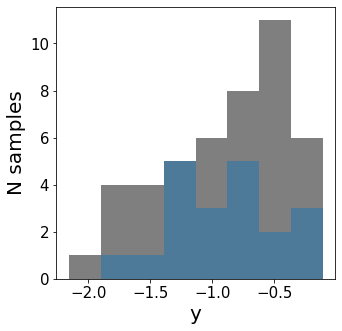

In [3]:
# comment this line out if preselection was performed
X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

# select method of split:
# random
# y_equidist - picks points that evenly span the output variable y. 
#              Normally doesn't pick highest/lowest values but this can be activated by changing the variable no_extrapolation in the respective section
# ks - Kennard Stone algorithm picks points based on an even distriution in feature space
# define - give a list of sample indices for either VS or TS in the corresponding code section 
# none - all samples in TS

# the numbers in the variables VS and TS refer to the original 0-indexed sample numbers 

split = "random"
test_ratio = 0.3 # means 70% in training set

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, random_state=randomstate+3, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
   # numbers according to sample lines in the excel sheet (that is, including indexes of 'excluded' samples)
    # for defining the TS, change the names of TS and VS in the next three lines
    #TS = [16,27,25,5,13,9,29,7]
    TS = []
    VS = [16,27,25,5,13,9,29,7]
    #TS = [i-1 for i in VS] # this can be commented out if 0-indexed numbers were defined above
    #VS = [i for i in range(X.shape[0]) if i not in VS and i not in exclude]
    TS = [i for i in range(X.syhape[0]) if i not in VS and i not in exclude]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
elif split == "ks":
    import kennardstonealgorithm as ks
    TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]
  
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   

elif split == "y_equidist":
    no_extrapolation = True
    
    import kennardstonealgorithm as ks
    if no_extrapolation:
        minmax = [np.argmin(y_sel),np.argmax(y_sel)]
        y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
        y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]
        
        # indices relative to y_ks:
        VS_ks,TS_ks = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*(2+np.shape(y_ks)[0])))
        # indices relative to y_sel:
        TS_ = sorted([y_ks_indices[i] for i in list(TS_ks)]+minmax)
        VS_ = sorted([y_ks_indices[i] for i in VS_ks])

    else:
        VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))
    
    X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]
    
    # indices relative to y
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
else: 
    raise ValueError("split option not recognized")
     

print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
# plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Feature Scaling 

In [4]:
# scale features by mean/variance, pick the relevant option (normally: StandardScaler)

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X_all)

print('done')

done


## Cross-terms/Interaction terms

In [ ]:
# Add polynomial features/interaction terms
# this is not yet implemented properly in some sections. 
# for 5.1-manual selection: specify cross-term with space between the components: x1 x40 + x6
# Essentially only section 5.2 can use cross-terms so far
# don't run this twice

polyfeats = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
X_train_p = polyfeats.fit_transform(X_train_sc)  #[:,[1,8,0]])
X_test_p = polyfeats.transform(X_test_sc)
X_all_p = polyfeats.transform(X_all_sc)

def add_to_x(matchobj):
    if "^" in matchobj.group(0):
        n = int(matchobj.group(0).split("^")[0])+1
        return("{} x{}".format(n,n))
    else:
        return(str(int(matchobj.group(0))+1))
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])



In [ ]:
# filter out non-significant crossterms based on p-value with target variable
p_val_cutoff = 0.005

r2s = []
pvals = []
for f_ind,feature in enumerate(X_train_p.T):
    slope, intercept, r_value, p_value, std_err = stats.linregress(feature, y_train)    
    r2s.append(r_value**2)
    pvals.append(p_value)
    
r2s_ = np.asarray(r2s)
pvals_ = np.asarray(pvals)

keep_p_ = [i[0] for i in np.argwhere(pvals_<p_val_cutoff) if i not in range(np.shape(X_all)[1])]
keep_p = [i for i in range(np.shape(X_all)[1])] + keep_p_

def sub_label_to_name(matchobj):
    return(X_labelname_dict[matchobj.group(0)])
def sub_labelname(matchobj):
    return(matchobj.group(0)+" "+X_labelname_dict[matchobj.group(0)])
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])
X_p_labels = list(np.reshape(pfnames[keep_p],len(keep_p)))
X_p_names = [re.sub("x[0-9]+",sub_label_to_name,st) for st in X_p_labels]
X_p_labelname = [re.sub("x[0-9]+",sub_labelname,st) for st in X_p_labels]

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train_p[:,keep_p])
X_test_sc = scaler.transform(X_test_p[:,keep_p])
X_all_sc = scaler.transform(X_all_p[:,keep_p])

X_labels = X_p_labels
X_names = X_p_names
X_labelname = X_p_labelname

print("{} cross-terms with p-value < {}".format(len(keep_p_),p_val_cutoff))

# Linear modelling, feature selection

## Manual selection of features

In [ ]:
#provide an x__ model (string, any order of terms)
features_x =  "x229 + x520 + x598 + x609"#
features_py = sorted([X_labels.index(i.strip()) for i in features_x.split("+")])

# features_py = []
#features = sorted([int(i[1:]) for i in re.findall("x\d+",features_x)])
#features_py = [i-1 for i in features]


X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
lr = Ridge(alpha=1E-5).fit(X_train_sel, y_train)

#lr = LinearRegression().fit(X_train_sel, y_train)
alphas = np.logspace(-6,3,10)

#for i in alphas:
#lr = Ridge(alpha=i).fit(X_train_sel, y_train)     
#print(f'\nalpha: {i}')
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores = repeated_k_fold(X_train_sel,y_train,k=5,n=200)

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores.mean(), kfoldscores.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))

# settings for plot and saving
#plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav="plotname",label="$ΔΔG^{≠}$",loo_pred=loo_train)
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="Yield",loo_pred=loo_train)
    

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
#print(model.summary())

print (y_pred_test) #prints out all predicted y values in a list - can also do this on training set
print (y_test) #prints experimental values
print(y_pred_train)
print(y_train)

In [ ]:
# add all individual features to the manual model
add_df = pd.DataFrame(index=X_labelname,columns=["label_sep","label_abs","Training R2","Training Q2"],dtype=float)

update_model = False
for f_ind in range(len(X_labels)):
    features_iter = features_py + [f_ind]    
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    add_df.iloc[f_ind,:] = [X_labels[f_ind],"x"+str(f_ind+1),lr.score(X_train_sel, y_train),q2]

if update_model and X_labelname.index(add_df['Training Q2'].idxmax()) not in features_py:
    features_py.append(X_labelname.index(add_df['Training Q2'].idxmax()))
add_df.sort_values(by=['Training Q2'],ascending=False).head(20)

In [ ]:
# remove each individual feature from the manual model
print("\n"+" + ".join(["x"+str(i+1) for i in sorted(features_py)]))

rem_df = pd.DataFrame(index=[X_labelname[i] for i in features_py],
                      columns=["Training R2","Training Q2"])
for f_ind in features_py:
    features_iter = [i for i in features_py if i != f_ind]
#     print(feature, x_names[f_ind])
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    rem_df.loc[X_labelname[f_ind],:] = [lr.score(X_train_sel, y_train),q2]

rem_df.sort_values(by=['Training Q2'],ascending=False)

## Forward stepwise selection based on p-values

In [ ]:
# Forward stepwise selection based on p-value
# threshold values refer to p-value of individual features
threshold_in = 0.05
threshold_out = 0.075 # must be larger than threshold_in

use_manual_feats = False # if True, model from previous section will be used as starting point

import stepwise_selection2 as step_s
if not use_manual_feats:
    features_py=[]

features_py = step_s.stepwise_selection(pd.DataFrame(X_train_sc), y_train,
                    initial_list=features_py,threshold_in=threshold_in,threshold_out=threshold_out,verbose=True)

print("\n"+" + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\n"+" + ".join([X_labelname[i] for i in sorted(features_py)]))

X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
lr = RidgeCV(alphas=np.logspace(-6,3,10), cv=3).fit(X_train_sel, y_train) 
print(f'\nalpha: {lr.alpha_}')
#lr = LinearRegression().fit(X_train_sel, y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100,reg=LinearRegression())

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")


testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu)) 
    
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="",loo_pred=loo_train)


## other forward feature selection implementations

In [ ]:
#Scikit-learn - forward feature selection
# largely useless
# options for criteria: 
# mutual_info_regression, f_regression
# select number of features with k
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

criteria = f_regression
skb = SelectKBest(criteria,k=4).fit(X_train_sc,y_train)
selected_feats = skb.get_support(indices=True)
print(" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([X_names[i] for i in sorted(selected_feats)]))

X_train_sel = skb.transform(X_train_sc)
X_test_sel = skb.transform(X_test_sc)
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train)

y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
# keepmodels.append(features_py)

In [ ]:
# Forward stepwise selection based on AIC ("aic") or Q2 ("q2")
criteria = "aic"
#criteria = "q2"

import forwardselect_q5 as fsq

df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))

newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
a,b = fsq.Forward_Select(df,"y","Regression",criteria)
selected_feats = [int(i[1:]) for i in b]

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print(" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([X_names[i] for i in sorted(selected_feats)]))

X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train)
print("\n\n")
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
# keepmodels.append(features_py)

## Forward stepwise selection keeping a set of candidates at each step

### Model search

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 65.6584
Step 3
cutpar:  1
cutpar:  1
cutpar:  1
Step 4
cutpar:  1
cutpar:  1
cutpar:  1
Step 5
cutpar:  2
cutpar:  2
cutpar:  2
Step 6
cutpar:  2
cutpar:  2
cutpar:  2
Step 7
cutpar:  2
cutpar:  2
cutpar:  2
Step 8
cutpar:  3
cutpar:  3
cutpar:  3
Step 9
cutpar:  3
cutpar:  3
cutpar:  3
Done. Time taken (minutes): 11.83

Split method: random
Test ratio: 0.3


Best model:
1 + x127 + x164 + x605 + x683 + x846 + x897 + x899 + x914 + x935
1 + FMN_B1_31-13_MD_wt + 66_PA_max + 342_B1_2-5_min + dynam_SA_66_100_177 + 232_phi-max + NBO_alpha_C_pdt + NBO_alpha_C_pdt_max + NBO_beta_H_pdt_max + N_lg_sterimol_L_sub_min

Features: x127 + x164 + x605 + x683 + x846 + x897 + x899 + x914 + x935

Parameters:
   -0.8963 + 
   -0.1859 * x127 FMN_B1_31-13_MD_wt
    0.1523 * x164 66_PA_max
   -0.2683 * x605 dynam_SA_66_100_177
   -0.1047 * x683 232_phi-max
   -0.0582 * x846 pdt_dynam_vol_total
    0.2138 * x897 NBO_alpha_C_pdt
   -0.1380 * x8

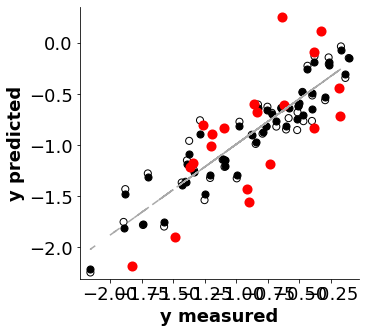

In [5]:
# Forward stepwise selection keeping a set of candidates at each step
n_steps = 9 #limit to number of features we want, will find those with less
n_candidates = 10 #smaller number of candidates speeds up code but often misses models - robust screen number of candidates = parameteres - steps
collin_criteria = 0.5 # this is R2
skipfeatures = [] #["x4","x3"]

import ForwardStepCandidates_2 as fsc
df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
df.drop(skipfeatures,axis=1,inplace=True)

results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df,'y',
                    n_steps=n_steps,n_candidates=n_candidates,collin_criteria=collin_criteria)
model_sel = results.loc[0,"Model"]
selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("\nBest model:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)

In [53]:
# Forward stepwise selection keeping a set of candidates at each step
# This iteratively computes the test R^2 for model sorting
n_steps = 9 #limit to number of features we want, will find those with less
n_candidates = 200 #smaller number of candidates speeds up code but often misses models - robust screen number of candidates = parameteres - steps
collin_criteria = 0.5 # this is R2
skipfeatures = [] #["x4","x3"]

import ForwardStepCandidates_2 as fsc
df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
df.drop(skipfeatures,axis=1,inplace=True)

results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df,'y',n_steps=n_steps,n_candidates=n_candidates,collin_criteria=collin_criteria)

def get_MAE(X_train_sel, y_train):
    return lr.score(X_train_sel, y_train)

def test_R2(y_train,y_pred_train):
    return metrics.mean_absolute_error(y_train,y_pred_train)

test_r2 = []
mae = []

#iterate all models and get the scores
for index, row in results.iterrows():
    
    model_sel = results.loc[index,"Model"]
    selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
    X_train_sel = X_train_sc[:,selected_feats]
    X_test_sel = X_test_sc[:,selected_feats]

    lr = LinearRegression().fit(X_train_sel,y_train)

    y_pred_train = lr.predict(X_train_sel)
    y_pred_test =  lr.predict(X_test_sel)
    
    test_r2.append(get_MAE(X_test_sel, y_test))
    mae.append(test_R2(y_test,y_pred_test))

selmods = results.sort_values(by=['Q^2'],ascending=False)
selmods['Test_R2'] = test_r2
selmods['MAE'] = mae

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 66.5448
Step 3
cutpar:  1
cutpar:  1
cutpar:  1
Step 4
cutpar:  1
cutpar:  1
cutpar:  1
Step 5
cutpar:  2
cutpar:  2
cutpar:  2
Step 6
cutpar:  2
cutpar:  2
cutpar:  2
Step 7
cutpar:  2
cutpar:  2
cutpar:  2
Step 8
cutpar:  3
cutpar:  3
cutpar:  3
Step 9
cutpar:  3
cutpar:  3
cutpar:  3
Done. Time taken (minutes): 667.53


### View models as list

In [54]:
# view best model
selmods.sort_values(by=['Test_R2'],ascending=False).head(30)

,Model,n_terms,R^2,Q^2,Test_R2,MAE
84188,"(x527, x589, x637)",3,0.622201,0.552483,0.783202,0.169302
70992,"(x289, x316, x768, x912, x92, x934)",6,0.768930,0.666814,0.772339,0.154508
76343,"(x578, x589, x614)",3,0.676546,0.617971,0.771238,0.166714
55582,"(x279, x309, x486, x586, x605, x933)",6,0.807970,0.726651,0.763501,0.164527
71469,"(x425, x520, x605, x622, x837, x913, x933)",7,0.775305,0.662339,0.761060,0.170032
71632,"(x514, x578, x586, x614, x70)",5,0.747251,0.660898,0.759285,0.165937
62064,"(x160, x221, x441, x731, x768, x912, x933)",7,0.796780,0.699213,0.755724,0.164654
81973,"(x225, x513, x520, x597, x816, x835, x934)",7,0.721059,0.575946,0.754318,0.192685
71575,"(x121, x221, x605, x794, x830, x912, x933)",7,0.770359,0.661357,0.753604,0.179914
69907,"(x374, x527, x589, x637, x797)",5,0.749748,0.675024,0.753472,0.189588


### Filter results

In [52]:
#### Change this to update sorting criteria ###
selmods2 = selmods[selmods.n_terms <=6].sort_values(by=['Test_R2'],ascending=False)
selmods2.head()

,Model,n_terms,R^2,Q^2,Test_R2,MAE
34339,"(x112, x605, x768, x910, x912)",5,0.789972,0.716891,0.745342,0.208886
34599,"(x112, x605, x768, x910, x913)",5,0.789103,0.715000,0.745290,0.206834
34302,"(x112, x605, x768, x908, x913)",5,0.789282,0.717129,0.744206,0.208194
33979,"(x112, x605, x768, x908, x912)",5,0.790205,0.719054,0.739667,0.210355
34185,"(x112, x605, x768, x907, x913)",5,0.789580,0.717840,0.734756,0.212040


In [ ]:
# example for filtering results
#filter to find models containing specified parameters

l1 = [(80, 276, 589)] 
l2 = []
for i,j,k in l1:
    a = "x{}".format(i) and "x{}".format(j) and "x{}".format(k)
    l2.append(a)

selmods2 = results.loc[[i for i in results.index if any(x in l2 for x in results.loc[i,'Model']) and "x200" not in results.loc[i,"Model"]]].sort_values(by=['Q^2'],ascending=False)
selmods2.head(20)

In [ ]:
# example for filtering results

selmods2 = results.loc[[i for i in results.index if "x113" in results.loc[i,"Model"] and "x49" not in results.loc[i,"Model"]]][results.n_terms < 5].sort_values(by=['Q^2'],ascending=False)
selmods2

In [ ]:
# filter models that contain more than one term that is also in a reference model
reference_model = 0 # this number refer to the index in 'results' or 'selmods', whichever is used 
use_df = results # or: selmods

uniquemods = {use_df.loc[reference_model,"Model"]:reference_model}
for ind in use_df.index:
    selmod = use_df.loc[ind,"Model"]
    if len(selmod) <= 2:
        continue
        
    add = True
    for mod in uniquemods.keys():
        if len([i for i in mod if i in selmod]) >= 2:
            add = False
            break
    if add:      
        uniquemods[use_df.loc[ind,"Model"]] = ind
    
    
print(len(uniquemods.keys()))
selmods2 = results.loc[uniquemods.values()]
selmods2

### Visualize models

Split method: random
Test ratio: 0.3

1 + x289 + x316 + x768 + x912 + x92 + x934
1 + 175_angle_4_min + 175_B5_5-6_max + 177_rmsd-b_min + NBO_beta_H_pdt + dynam_vol_66 + N_lg_sterimol_L_sub_max

Features: x92 + x289 + x316 + x768 + x912 + x934

Parameters:
   -0.8963 + 
   -0.2943 * x92 dynam_vol_66
    0.0356 * x289 175_angle_4_min
   -0.1346 * x316 175_B5_5-6_max
   -0.1472 * x768 177_rmsd-b_min
   -0.2792 * x912 NBO_beta_H_pdt
   -0.0850 * x934 N_lg_sterimol_L_sub_max

Training R2  = 0.769
Training Q2  = 0.667
Training MAE = 0.199
Training K-fold R2 = 0.648 (+/- 0.002)

Test R2      = 0.772
Test MAE     = 0.155


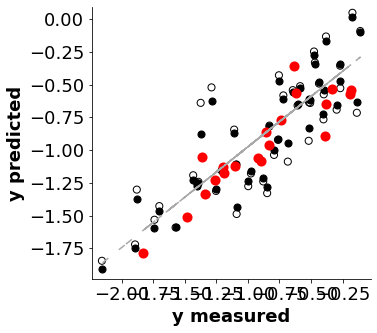

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     21.08
Date:                Wed, 03 Aug 2022   Prob (F-statistic):           1.04e-10
Time:                        08:16:05   Log-Likelihood:                -1.3302
No. Observations:                  45   AIC:                             16.66
Df Residuals:                      38   BIC:                             29.31
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8963      0.040    -22.169      0.0

In [55]:
# visualize other models
model_sel = results.loc[70992,"Model"]

#models we like 11308

#other ways of selecting models:
# model_sel = results.iloc[selmods.index[3],0]
# model_sel = results.iloc[785,0]
# model_sel = ("x100","x31")


selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]

print("Split method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)



print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")


testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

In [ ]:
# print all models that are within a specified criteria (if statement below)
# results.index will look at all models, selmods.index will look at filtered models

#for i in results.index:
for i in selmods.index:
    model_sel = results.loc[i,"Model"]
    
    #other ways of selecting models:
    # model_sel = results.iloc[selmods.index[3],0]
    # model_sel = results.iloc[785,0]
    # model_sel = ("x100","x31")
    
    
    selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
    X_train_sel = X_train_sc[:,selected_feats]
    X_test_sel = X_test_sc[:,selected_feats]
    print(models[model_sel].formula)
    print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
    lr = LinearRegression().fit(X_train_sel,y_train)
    y_pred_train = lr.predict(X_train_sel)
    y_pred_test =  lr.predict(X_test_sel)
    
    q2,loo_train = loo.q2(X_train_sel,y_train)
    kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)
    
    testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
    trainr2 = lr.score(X_train_sel, y_train)
    
    #set criteria here 
    if testr2 >= 0.65 and q2>=0.6:
        print("\nSplit method: {}".format(split))
        print("Test ratio: {}\n".format(test_ratio))
        
        print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
        print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))
        
        print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
        print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")
        
        print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
        print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")
    
        if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
            print("\n"+random.choice(insu))
        
        plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)
    
        #model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
        #print(model.summary())
        
    print("____________________________________________________________________________________")

# Other

## Ridge Regression, no feature selection 

In [ ]:
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

linm = Ridge().fit(X_train_sc, y_train)

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,4,9)
for parm in parm_range:
    print(parm)
    linm = Ridge(alpha=parm).fit(X_train_sc, y_train)
    q2,loo_train = loo.q2(X_train_sc,y_train,Ridge(alpha=parm))
    
    y_pred_train = linm.predict(X_train_sc)
    y_pred_test =  linm.predict(X_test_sc)
    #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(linm.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
        
    r2s.append(linm.score(X_train_sc, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
linm = Ridge(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = linm.predict(X_train_sc)
y_pred_test =  linm.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

## Lasso feature selection

In [ ]:
# Lasso feature selection
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,1,6)
for parm in parm_range:
    print(parm)
    lasso = Lasso(alpha=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(lasso.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(lasso.coef_!=0)[0]]
    try:
        q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
        lr = LinearRegression().fit(X_train_sel,y_train)
        y_pred_train = lr.predict(X_train_sel)
        y_pred_test =  lr.predict(X_test_sel)
        #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
        print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
        #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
    except:
        pass
    print("     Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
    # print(np.where(lr.coef_ != 0)[1])
    
    r2s.append(lasso.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
lasso = Lasso(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = lasso.predict(X_train_sc)
y_pred_test =  lasso.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    
    
# llbic = LassoLarsIC(criterion="bic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llbic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llbic.coef_!=0)[0]]
# print("\n\nLassoLarsIC bic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llbic.score(X_train_sc, y_train),q2,llbic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llbic.coef_ != 0)))

# llaic = LassoLarsIC(criterion="aic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llaic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llaic.coef_!=0)[0]]
# print("\n\nLassoLarsIC aic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llaic.score(X_train_sc, y_train),q2,llaic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llaic.coef_ != 0)))

# lassocv = LassoCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(lassocv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(lassocv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nLassoCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lassocv.score(X_train_sc, y_train),q2,lassocv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(lassocv.coef_ != 0)))
# print(np.where(lassocv.coef_ != 0)[1])

llcv = LassoLarsCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(llcv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(llcv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
print("\n\nLassoLarsCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llcv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(llcv.coef_ != 0)))
# print(np.where(llcv.coef_ != 0)[1])
y_pred_train = llcv.predict(X_train_sc)
y_pred_test =  llcv.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    



## Elastic Net

In [ ]:
%%time
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

encv = ElasticNetCV(l1_ratio=[.01,.05,.66,.1,.2,.3, .5, .7, .9, .95, .99, 1],
#                     n_alphas=500,
                    alphas=np.logspace(-1,4,100),
                    cv=3,n_jobs=-1,max_iter=1000000).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(encv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(encv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,Ridge(alpha=encv.alpha_))
y_pred_train = encv.predict(X_train_sc)
y_pred_test =  encv.predict(X_test_sc)
print("\n\nElasticNetCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(encv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(encv.coef_ != 0)))
print("Best hyperparameters: l1_ratio = {}, alpha = {}".format(encv.l1_ratio_,encv.alpha_))


plot_fit(y_train,y_pred_train,y_test,y_pred_test) 


## Orthogonal Matching Pursuit

In [ ]:
# Orthogonal Matching Pursuit
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

parm_range = range(1,10)
print(np.shape(X_train_sc))
print(np.shape(y_train))
for parm in parm_range:
    print(parm)
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(omp.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(omp.coef_!=0)[0]]
    q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
    y_pred_train = omp.predict(X_train_sc)
    y_pred_test =  omp.predict(X_test_sc)
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(omp.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

    print("     "+" + ".join(["x"+str(i+1) for i in np.where(omp.coef_ != 0)[0]]))
    #print("     Number of features used: {}".format(np.sum(lr.coef_ != 0)))
    

# ompcv = OrthogonalMatchingPursuitCV(cv=LeaveOneOut(),n_jobs=-1).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(ompcv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(ompcv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nOrthogonalMatchingPursuitCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(ompcv.score(X_train_sc, y_train),q2,ompcv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(ompcv.coef_ != 0)))

# print("\n"+" + ".join(["x"+str(i+1) for i in np.where(ompcv.coef_!=0)[0]]))
# print("\n"+" + ".join([X_names[i] for i in np.where(ompcv.coef_!=0)[0]]))

# y_pred_train = ompcv.predict(X_train_sc)
# y_pred_test =  ompcv.predict(X_test_sc)
# plot_fit(y_train,y_pred_train,y_test,y_pred_test)


## Nonlinear Modelling

### Kernel Ridge Regression 

In [ ]:
# Kernel Ridge Regression 
# kernel options: linear, poly, rbf
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio)) 

r2s = []
q2s = []
parms = []
print("\n\nKernelRidge")

kernel="poly" #rbf (only works if properties are related)
degree=2  #2 simulates crossterms 

parm_range = np.logspace(-3,3,7)
for parm in parm_range:
    print(parm)
    kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=parm
    ).fit(X_train_sc, y_train)
    y_pred_train = kr.predict(X_train_sc)
    y_pred_test =  kr.predict(X_test_sc)
    q2,loo_train = loo.q2(X_train_sc,y_train,KernelRidge(kernel=kernel,degree=degree,alpha=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        kr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(kr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = kr.predict(X_train_sc)
y_pred_test =  kr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)



### Support Vector Regression

In [ ]:
# SVR
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

r2s = []
q2s = []
parms = []
print("\n\nSupport Vector Regression")

kernel="poly"
degree=2
gamma="auto"

parm_range = np.logspace(-3,3,15)
for parm in parm_range:
    print("{:.2E}".format(parm))
    svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=parm
    ).fit(X_train_sc, y_train)
    y_pred_train = svr.predict(X_train_sc)
    y_pred_test =  svr.predict(X_test_sc)
    q2,loo_train = loo.q2(X_train_sc,y_train,SVR(kernel=kernel,degree=degree,gamma=gamma,C=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        svr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(svr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = svr.predict(X_train_sc)
y_pred_test =  svr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)
   

# keepmodels_[svr] = ()

### Regression with Principal Components

In [ ]:
# Regression with Principal Components

for npca in range(1,9):
    pca = PCA(n_components=npca)
    pca.fit(scaler.transform(X_sel))
#     pca.fit(X_train_sc)
    X_train_pca = pca.transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)

    pca_score = pca.explained_variance_ratio_
    pca_values = pca.singular_values_
    V = pca.components_

    linr = LinearRegression().fit(X_train_pca, y_train)
#     linr = Ridge(alpha=1).fit(X_train_pca,y_train)
    y_pred_train = linr.predict(X_train_pca)
    y_pred_test =  linr.predict(X_test_pca)
    q2,loo_train = loo.q2(X_train_pca,y_train,LinearRegression())
    print("\nSplit method: {}".format(split))
    print("Test ratio: {}".format(test_ratio))
    print("\nPC Regression {}".format(npca))
    print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        linr.score(X_train_pca, y_train),q2,r2_val(y_test,y_pred_test,y_train)))



    plot_fit(y_train,y_pred_train,y_test,y_pred_test)

    
# # virtual screening
# X_screen_sel = pca.transform(X_all_sc)
# y_pred_vscreen = linr.predict(X_screen_sel)
# y_vscreen["PCA5"] = y_pred_vscreen


# keepmodels_[PCA(n_components=2).fit(scaler.transform(X_sel))] = ("n_components=2")

### Random Forest

In [ ]:
%%time
# Random forest regression

rf  = RandomForestRegressor(n_estimators=500,random_state=42,n_jobs=None,max_features=None,max_depth=None).fit(
    X_train_sc, y_train)
# rf = GradientBoostingRegressor(
#     n_estimators=50,
#     subsample=.6,
#     max_depth=2,
#     random_state=42,
#     max_features=None,
#     alpha=0.9,
#     ).fit(X_train_sc, y_train)
y_pred_train = rf.predict(X_train_sc)
y_pred_test =  rf.predict(X_test_sc)
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))
print("Training R2;Test R2;{:.2f};{:.2f}".format(
    rf.score(X_train_sc, y_train),r2_val(y_test,y_pred_test,y_train)))
# print(np.where(llcv.coef_ != 0)[1])

plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

# keepmodels_[rf] = ()